In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
# read in data
df = pd.read_csv('reviews_cleaned.csv')
df = df.astype({'commentWords':'string'})
df.columns = ['id', "clarityRating", "helpfulRating", "difficultyRating", "qualityRating", 
             "comment", "commentWords"]
df.head()

,id,clarityRating,helpfulRating,difficultyRating,qualityRating,comment,commentWords
0,0,5,5,1,5.0,He is amazing! I had lots of fun in his class....,amazing lot fun class get use may seem little ...
1,1,2,1,2,1.5,"Bad prof, simply put. Thankfully, Borgen is ap...",bad prof simply put thankfully apparently reti...
2,2,2,1,2,1.5,"Pretentious, disorganized, rants, and goes off...",pretentious disorganize rant go tangent readin...
3,3,2,2,3,2.0,"Very disorganized in lecture, does not go into...",disorganize lecture not go detail explain term...
4,4,3,2,2,2.5,"Pretentious, scatter brained, and enjoys belit...",pretentious scatter brain enjoy student stupid...


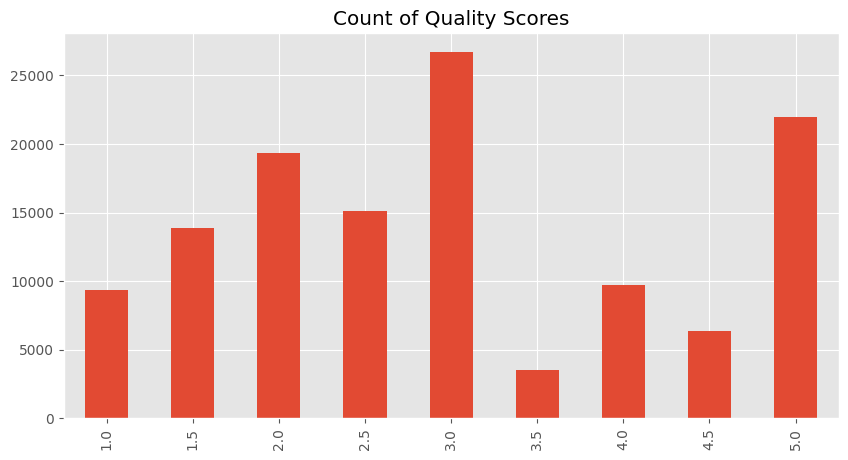

In [3]:
## quick eda

clarityx = df['clarityRating'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Count of Clarity Scores', 
          figsize=(10, 5))

helpfulx = df['helpfulRating'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Count of Helpful Scores', 
          figsize=(10, 5))

difficultyx = df['difficultyRating'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Count of Difficulty Scores', 
          figsize=(10, 5))

qualityx = df['qualityRating'].value_counts().sort_index() \
    .plot(kind='bar', 
          title='Count of Quality Scores', 
          figsize=(10, 5))

In [4]:
## basic nltk

example = df['comment'][50]
print(example)

Funny prof. Class is weird. Everything is graded by your TA, so that's all that really matters. The TA helps with a lot of stuff that no one understands from lecture. a midterm, term paper, and final. I feel like my TA graded fairly easy. Lots of the terms on the review sheets I looked up on wikipedia and still got an a in the class. but then i nev


## Vader Sentiment Score

In [39]:
from nltk.sentiment import SentimentIntensityAnalyzer as nltksia
from tqdm import tqdm

sia = nltksia()

In [42]:
# run polarity on entire dataset

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['commentWords']
    myid = row['id']
    if not pd.isna(text):
        res[myid] = sia.polarity_scores(text)


100%|███████████████████████████████████| 64865/64865 [00:32<00:00, 1990.14it/s]


In [43]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

In [44]:
## sentiment score merged with og dataframe
vaders.head()

,id,neg,neu,pos,compound,clarityRating,helpfulRating,difficultyRating,qualityRating,comment,commentWords
0,0,0.118,0.467,0.415,0.7251,5,5,1,5.0,He is amazing! I had lots of fun in his class....,amazing lot fun class get use may seem little ...
1,1,0.198,0.653,0.149,-0.4774,2,1,2,1.5,"Bad prof, simply put. Thankfully, Borgen is ap...",bad prof simply put thankfully apparently reti...
2,2,0.277,0.534,0.189,-0.3553,2,1,2,1.5,"Pretentious, disorganized, rants, and goes off...",pretentious disorganize rant go tangent readin...
3,3,0.064,0.936,0.000,-0.2755,2,2,3,2.0,"Very disorganized in lecture, does not go into...",disorganize lecture not go detail explain term...
4,4,0.299,0.530,0.170,-0.5274,3,2,2,2.5,"Pretentious, scatter brained, and enjoys belit...",pretentious scatter brain enjoy student stupid...


## Plot VADER results

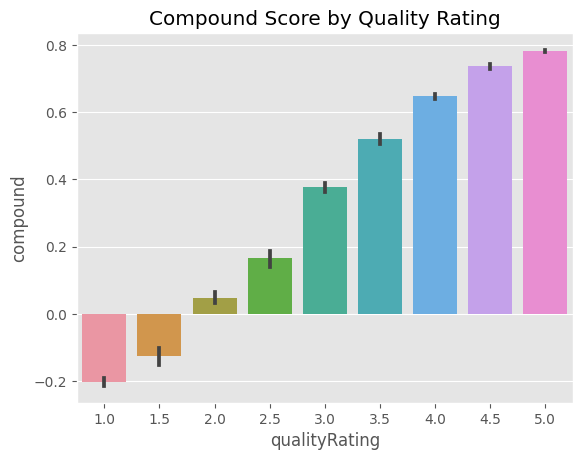

In [45]:
ax = sns.barplot(data=vaders, x='qualityRating', y='compound')
ax.set_title('Compound Score by Quality Rating')
plt.show()

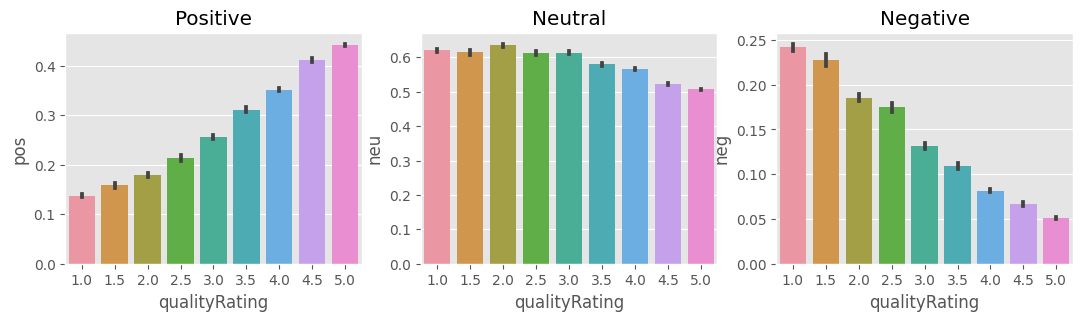

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(13, 3))
sns.barplot(data=vaders, x='qualityRating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='qualityRating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='qualityRating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

## Roberta Model

In [47]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [48]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [49]:
# Vader Results
print(example)
sia.polarity_scores(example)

Funny prof. Class is weird. Everything is graded by your TA, so that's all that really matters. The TA helps with a lot of stuff that no one understands from lecture. a midterm, term paper, and final. I feel like my TA graded fairly easy. Lots of the terms on the review sheets I looked up on wikipedia and still got an a in the class. but then i nev


{'neg': 0.043, 'neu': 0.831, 'pos': 0.126, 'compound': 0.5714}

In [50]:
# Roberta Results
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.101287134, 'roberta_neu': 0.33128077, 'roberta_pos': 0.5674321}


In [51]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [52]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df), leave=True):
    text = row['commentWords']
    myid = row['id']
    if not pd.isna(text):
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    

100%|█████████████████████████████████████| 64865/64865 [48:28<00:00, 22.30it/s]


In [54]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')

In [55]:
results_df.head()

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,clarityRating,helpfulRating,difficultyRating,qualityRating,comment,commentWords
0,0,0.118,0.467,0.415,0.7251,0.015330,0.088428,0.896243,5,5,1,5.0,He is amazing! I had lots of fun in his class....,amazing lot fun class get use may seem little ...
1,1,0.198,0.653,0.149,-0.4774,0.923688,0.071005,0.005307,2,1,2,1.5,"Bad prof, simply put. Thankfully, Borgen is ap...",bad prof simply put thankfully apparently reti...
2,2,0.277,0.534,0.189,-0.3553,0.855101,0.130430,0.014469,2,1,2,1.5,"Pretentious, disorganized, rants, and goes off...",pretentious disorganize rant go tangent readin...
3,3,0.064,0.936,0.000,-0.2755,0.841245,0.148420,0.010335,2,2,3,2.0,"Very disorganized in lecture, does not go into...",disorganize lecture not go detail explain term...
4,4,0.299,0.530,0.170,-0.5274,0.825411,0.159682,0.014906,3,2,2,2.5,"Pretentious, scatter brained, and enjoys belit...",pretentious scatter brain enjoy student stupid...


## Comparison between models

In [56]:
results_df.columns

Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'clarityRating',
       'helpfulRating', 'difficultyRating', 'qualityRating', 'comment',
       'commentWords'],
      dtype='object')

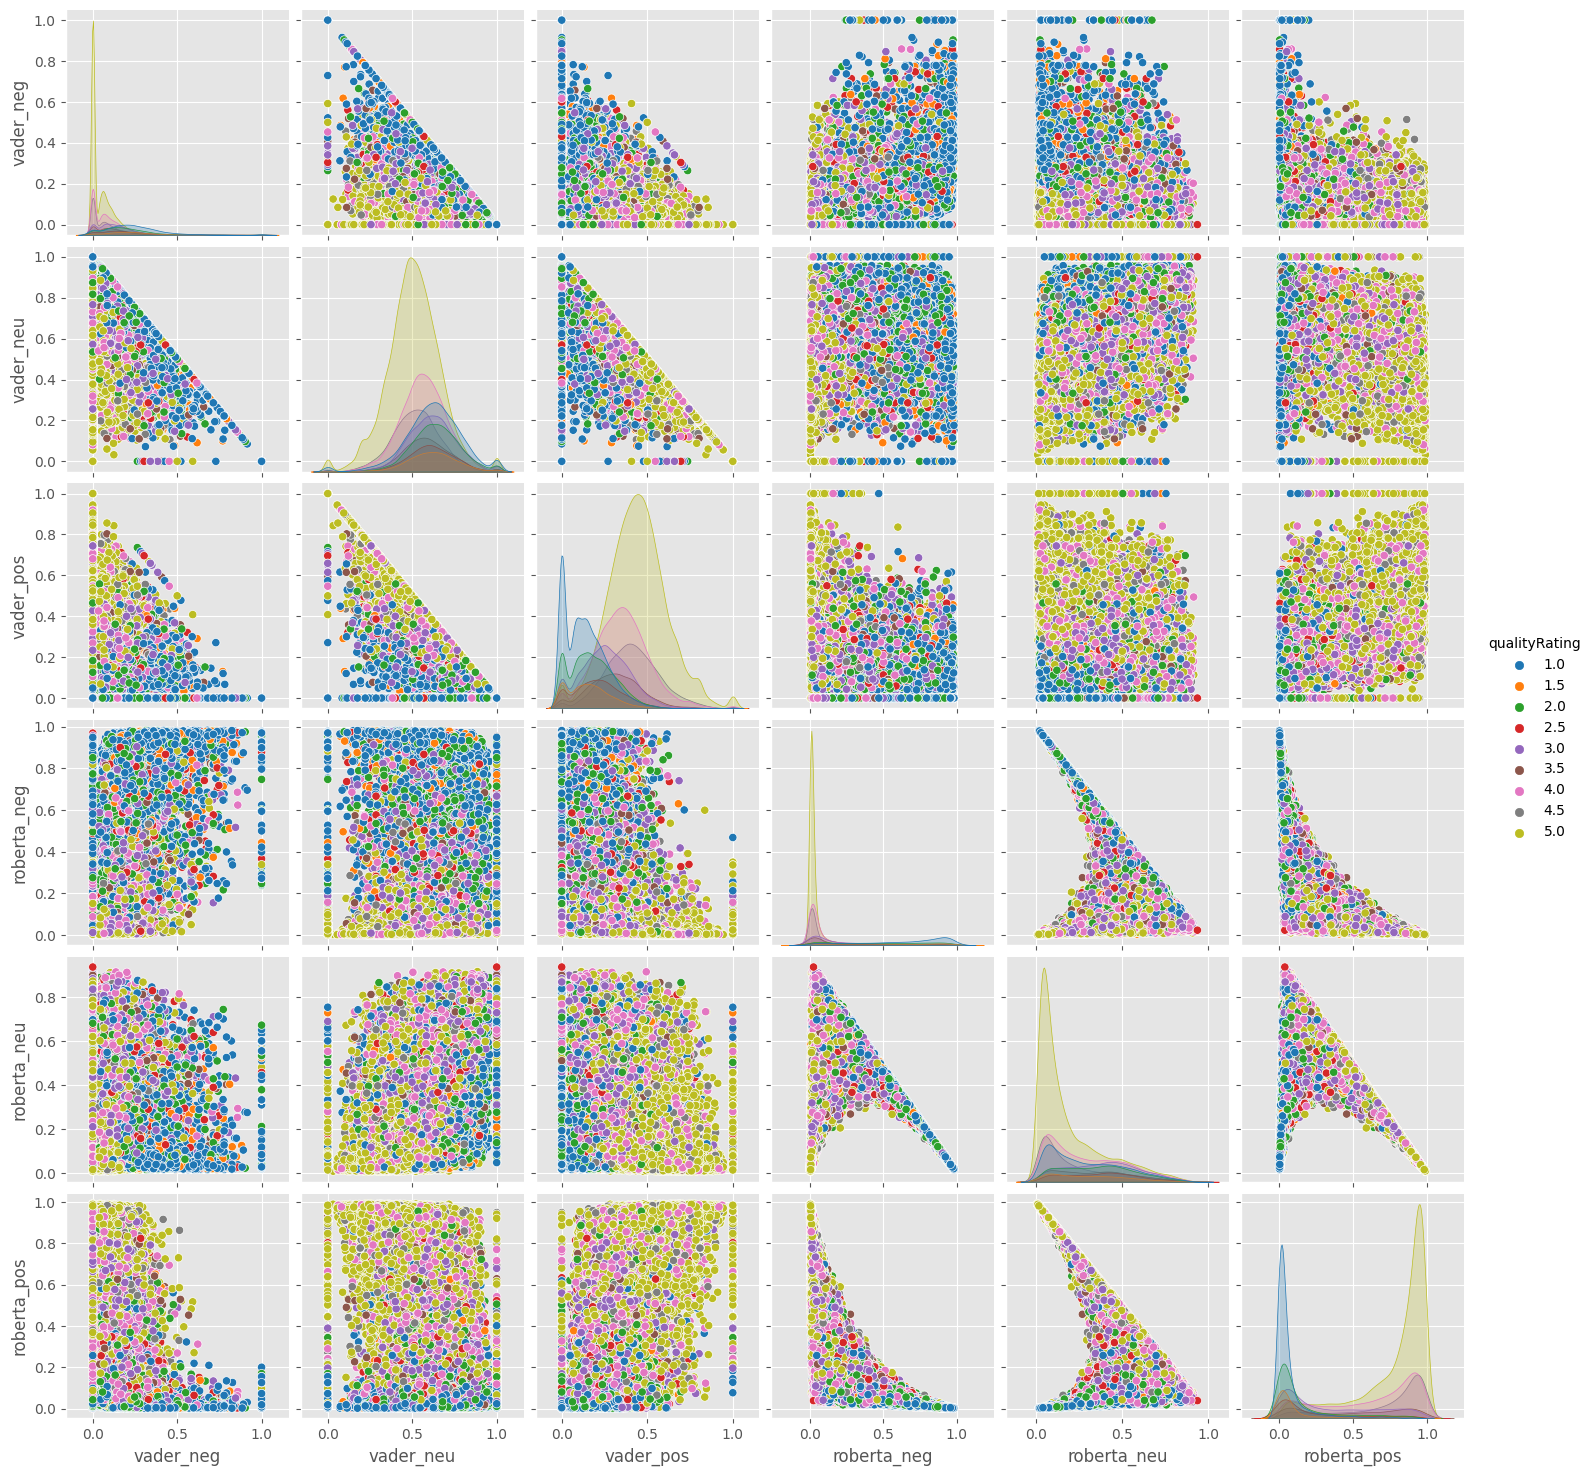

In [60]:
sns.pairplot(data=results_df,
            vars=['vader_neg', 'vader_neu', 'vader_pos', 
                 'roberta_neg', 'roberta_neu', 'roberta_pos',],
            hue = 'qualityRating',
            palette='tab10')
plt.show()

## Review Examples

Lets look at some examples where the model scoring and professor score differ the most.

In [61]:
results_df.query('qualityRating == 1') \
    .sort_values('roberta_pos', ascending=False)['commentWords'].values[0]

'hard understand lecture super long study sure pass class offer extra credit pretty awesome'

In [62]:
results_df.query('qualityRating == 1') \
    .sort_values('vader_pos', ascending=False)['commentWords'].values[0]

'beautiful'

# negative sentiment 5-star view

In [63]:
results_df.query('qualityRating == 5') \
    .sort_values('roberta_pos', ascending=False)['commentWords'].values[0]

'love far favorite professor highly recommend great lecture fair exam overall sweet love u mona'

In [65]:
results_df.query('qualityRating == 5') \
    .sort_values('vader_pos', ascending=False)['commentWords'].values[0]

'amaze'